In [1]:
#install dependencies
!pip3 install numpy scipy matplotlib schemdraw

import numpy as np
import matplotlib.pyplot as plt
import itertools

!python3 -m pip install --upgrade pip
!python3 -m pip install jax jaxlib

import jax
import jax.numpy as jnp
from jax import random, lax, vmap
from jax import jit

## Capturing Spin Configurations at Specific Times

In this section I am creating an Ising model using Monte Carlo Markov Chains (MCMC) and capturing spin configurations at specific times during the simulation.

### Ising model

The Ising model is a mathematical model used in statistical mechanics to describe ferromagnetism in materials. It consists of discrete variables, called spins, which can be in one of two states (+1 or -1). The spins are arranged in a lattice, allowing them to interact with their nearest neighbors. The model captures how these interactions, along with external magnetic fields and thermal fluctuations, influence the overall magnetic properties of the material. The Metropolis-Hastings algorithm is utilized to evolve the spin configurations of a 2D lattice over time, allowing us to study the system's behavior under different conditions.


### Key Components:

1. **Initialization**:
    - The spins in the lattice are initialized randomly to either -1 or 1, representing two possible spin states.

2. **Hamiltonian Function**:
    - The Hamiltonian function calculates the energy of a given spin configuration based on the interactions between neighboring spins. This energy calculation is crucial for determining the probability of spin flips in the Metropolis-Hastings updates.

3. **Metropolis-Hastings Step**:
    - In each step, a spin is randomly selected, and the change in energy (delta E) is calculated if the spin were to flip. The algorithm then decides whether to accept the flip based on the Metropolis criterion, which depends on the change in energy and the temperature of the system.

4. **Monte Carlo Simulation**:
    - The simulation runs for a specified number of iterations at a given temperature. During the simulation, spin configurations are captured at specified times. This allows for the analysis of how the spin configurations evolve over time under the Ising model dynamics.

The purpose of this section is to model the behavior of spins in a ferromagnetic material and observe how they change over time using the Ising model and MCMC methods. By capturing spin configurations at specific times, we can study the dynamics and properties of the system at different stages of the simulation.


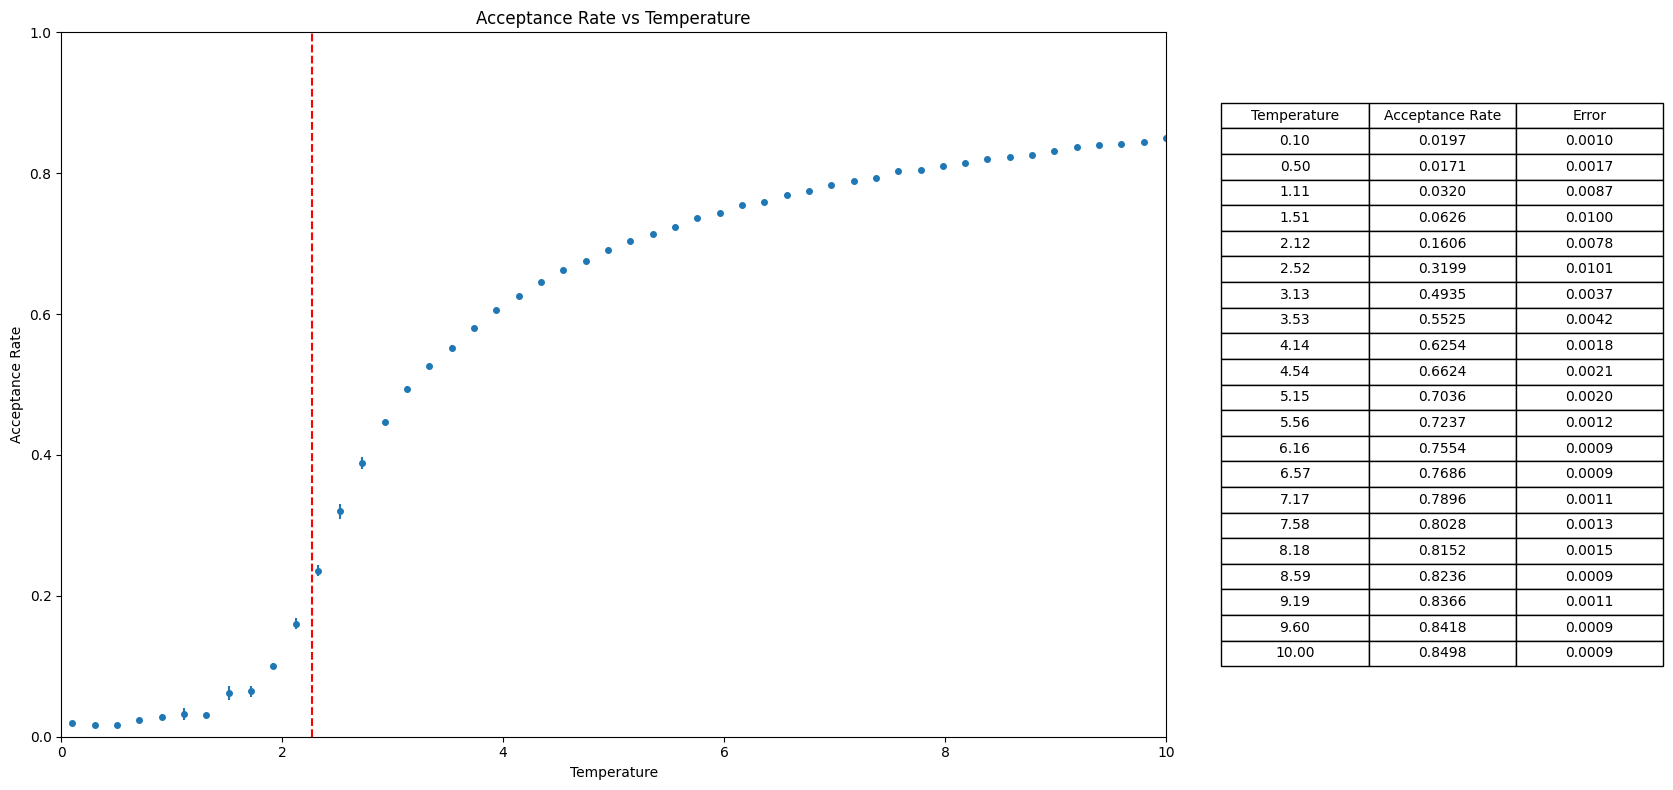

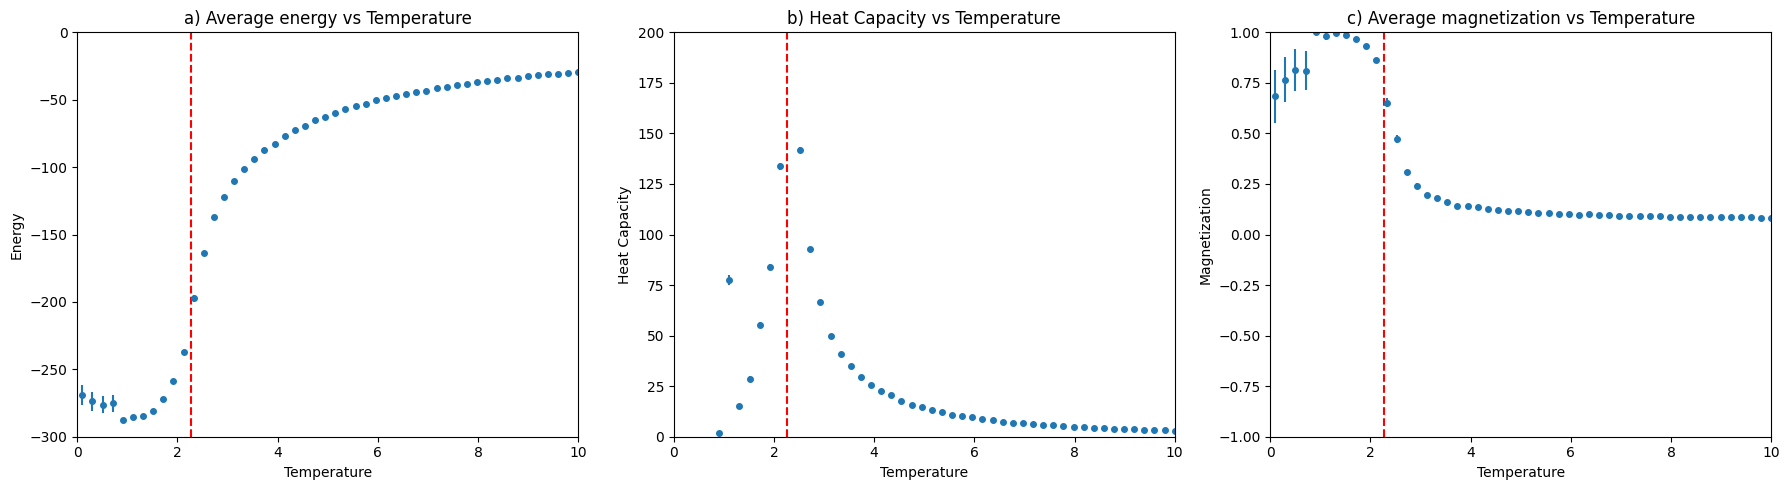

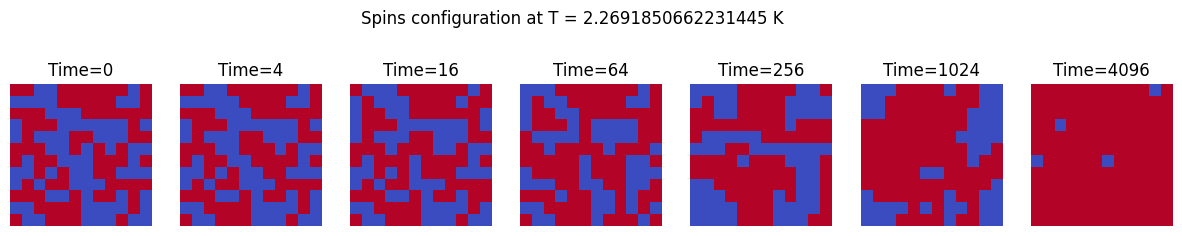

In [2]:
#capturing spin configurations at specific times
def capture_spin_configurations(L, iterations, temperature, theta, capture_times):
    key = random.PRNGKey(0)
    beta = 1.0 / temperature
    spins = initialize_spins(key, L)
    state = (spins, beta, key, theta)

    configurations = []
    current_iteration = 0
    for capture_time in capture_times:
        while current_iteration < capture_time:
            state, _ = lax.scan(step, state, None, length=capture_time - current_iteration)
            current_iteration = capture_time
        configurations.append(state[0])

    return configurations

#generating random spin configuration
def initialize_spins(key, L):
    spins = random.choice(key, jnp.array([-1, 1]), shape=(L, L)) #randomly choosing between -1 and 1
    return spins

@jit #hamiltonian function
def hamiltonian(spins, theta):
    L = spins.shape[0]
    H = -theta * jnp.sum(spins * (jnp.roll(spins, 1, axis=0) + jnp.roll(spins, 1, axis=1)))
    return H

@jit #single metropolis-hastings step
def step(state, _):
    spins, beta, key, theta = state
    L = spins.shape[0]
    i, j = random.randint(key, (2,), 0, L) #randomly chooses which bit to flip
    
    #change in energy
    delta_E = 2 * theta * spins[i, j] * (spins[i, (j+1) % L] + spins[i, (j-1) % L] + spins[(i+1) % L, j] + spins[(i-1) % L, j])
    
    key, subkey = random.split(key)
    accept = (delta_E < 0) | (random.uniform(subkey) < jnp.exp(-beta * delta_E))  
    spins = spins.at[i, j].set(lax.select(accept, -spins[i, j], spins[i, j]))
    return (spins, beta, key, theta), accept

#whole MCMC process
def mcmc(L, iterations, temperature_range, step_recording, num_runs, theta, thermalization):
    key = random.PRNGKey(0)
    all_energies = jnp.zeros((len(temperature_range), num_runs))
    all_energies_squared = jnp.zeros((len(temperature_range), num_runs))
    all_magnetizations = jnp.zeros((len(temperature_range), num_runs))
    all_acceptance_rates = jnp.zeros((len(temperature_range), num_runs))

    @jit #single MCMC iteration
    def single_temperature_mcmc(T, idx, run, all_energies, all_energies_squared, all_magnetizations, all_acceptance_rates, key):
        beta = 1.0 / T
        spins = initialize_spins(key, L)
        state = (spins, beta, key, theta)
        
        #thermalization
        state, accepts = lax.scan(step, state, None, length=thermalization)
        
        #sampling with step recording
        def sampling_update(state, _):
            state, _ = lax.scan(step, state, None, length=step_recording)
            energy = hamiltonian(state[0], theta)
            magnetization = jnp.abs(jnp.sum(state[0]) / (L * L))
            acceptance_rate = jnp.mean(accepts)
            return state, (energy, magnetization, acceptance_rate)
        
        state, results = lax.scan(sampling_update, state, None, length=(iterations - thermalization) // step_recording)
        energies, magnetizations, acceptance_rates = results

        avg_energy = jnp.mean(energies)
        all_energies = all_energies.at[idx, run].set(avg_energy)

        avg_energy_squared = jnp.mean(energies**2)
        all_energies_squared = all_energies_squared.at[idx, run].set(avg_energy_squared)

        avg_magnetization = jnp.mean(magnetizations)
        all_magnetizations = all_magnetizations.at[idx, run].set(avg_magnetization)
        
        avg_acceptance_rate = jnp.mean(acceptance_rates)
        all_acceptance_rates = all_acceptance_rates.at[idx, run].set(avg_acceptance_rate)
    
        return all_energies, all_energies_squared, all_magnetizations, all_acceptance_rates, state[0], key

    for run in range(num_runs):                     #run: current run number
        for idx, T in enumerate(temperature_range): #idx: index of temperature in the temperature range
            key, subkey = random.split(key)
            all_energies, all_energies_squared, all_magnetizations, all_acceptance_rates, initial_spins, key = single_temperature_mcmc(
                T, idx, run, all_energies, all_energies_squared, all_magnetizations, all_acceptance_rates, subkey)

    return all_energies, all_energies_squared, all_magnetizations, all_acceptance_rates

def main():

    L = 12  #grid size
    iterations = 100000
    thermalization = int(0.2 * iterations)
    step_recording = 10
    temperature_range = jnp.linspace(0.1, 10.0, 50)
    theta = 1.0
    k_B = 1.0
    num_runs = 10  #number of independent runs for averaging

    all_energies, all_energies_squared, all_magnetizations, all_acceptance_rates = mcmc(L, iterations, temperature_range, step_recording, num_runs, theta, thermalization)
    
    average_energies = jnp.mean(all_energies, axis=1)
    std_error_energies = jnp.std(all_energies, axis=1) / jnp.sqrt(num_runs)

    average_energies_squared = jnp.mean(all_energies_squared, axis=1)
    heat_capacities = (average_energies_squared - average_energies**2) / (temperature_range**2)
    heat_capacity_variance = (jnp.mean(all_energies_squared, axis=1) - jnp.mean(all_energies, axis=1)**2) / (temperature_range**4)
    std_error_heat_capacities = jnp.sqrt(heat_capacity_variance / num_runs)

    average_magnetizations = jnp.mean(all_magnetizations, axis=1)
    std_error_magnetizations = jnp.std(all_magnetizations, axis=1) / jnp.sqrt(num_runs)

    #------------------------ ACCEPTANCE RATE
    average_acceptance_rates = jnp.mean(all_acceptance_rates, axis=1)
    std_error_acceptance_rates = jnp.std(all_acceptance_rates, axis=1) / jnp.sqrt(num_runs)

    table_temperatures = np.arange(0.0, 10.5, 0.5)
    table_indices = np.searchsorted(temperature_range, table_temperatures)
    table_values = [(temperature_range[i], average_acceptance_rates[i], std_error_acceptance_rates[i]) for i in table_indices if i < len(temperature_range)]

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.errorbar(temperature_range, average_acceptance_rates, yerr=std_error_acceptance_rates, fmt='o', markersize=4)
    T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))
    ax.axvline(x=T_c, color='red', linestyle='--')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title('Acceptance Rate vs Temperature')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

    table_data = [[f"{T:.2f}", f"{rate:.4f}", f"{error:.4f}"] for T, rate, error in table_values]
    column_labels = ["Temperature", "Acceptance Rate", "Error"]
    table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='right', bbox=[1.05, 0.1, 0.4, 0.8])

    plt.tight_layout()
    plt.show()

    #------------------------ PLOTTING THE DATA
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #plot Average Energy vs Temperature
    axes[0].errorbar(temperature_range, average_energies, yerr=std_error_energies, fmt='o', markersize=4)
    T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))
    axes[0].axvline(x=T_c, color='red', linestyle='--')
    axes[0].set_xlim(0, 10)
    axes[0].set_ylim(-300, 0)
    axes[0].set_xlabel('Temperature')
    axes[0].set_ylabel('Energy')
    axes[0].set_title('a) Average energy vs Temperature')

    #plot Heat Capacity vs Temperature
    axes[1].errorbar(temperature_range, heat_capacities, yerr=std_error_heat_capacities, fmt='o', markersize=4)
    axes[1].axvline(x=T_c, color='red', linestyle='--')
    axes[1].set_xlim(0, 10)
    axes[1].set_ylim(0, 200)
    axes[1].set_xlabel('Temperature')
    axes[1].set_ylabel('Heat Capacity')
    axes[1].set_title('b) Heat Capacity vs Temperature')

    #plot Magnetization vs Temperature
    axes[2].errorbar(temperature_range, average_magnetizations, yerr=std_error_magnetizations, fmt='o', markersize=4)
    axes[2].axvline(x=T_c, color='red', linestyle='--')
    axes[2].set_xlim(0, 10)
    axes[2].set_ylim(-1, 1)
    axes[2].set_xlabel('Temperature')
    axes[2].set_ylabel('Magnetization')
    axes[2].set_title('c) Average magnetization vs Temperature')

    plt.tight_layout()
    plt.show()

    #------------------------ SPIN CONFIGURATIONS
    temperature = T_c
    capture_times = [0, 4, 16, 64, 256, 1024, 4096]
    configurations = capture_spin_configurations(L, iterations, temperature, theta, capture_times)

    #plotting spin configurations
    fig, axes = plt.subplots(1, len(capture_times), figsize=(15, 3))
    for ax, spins, time in zip(axes, configurations, capture_times):
        ax.imshow(spins, cmap='coolwarm')
        ax.set_title(f'Time={time}')
        ax.axis('off')
    plt.suptitle(f'Spins configuration at T = {temperature} K')
    plt.show()

main()

## Checking Ergodicity

Now we focus on verifying the ergodicity of the Monte Carlo simulation using the Ising model. 

### Ergodicity

Ergodicity is a fundamental concept in statistical mechanics and Markov Chain Monte Carlo (MCMC) methods. It refers to the property that, over a long period of time, the system will explore all accessible states of the configuration space with probabilities proportional to their equilibrium distribution. In other words, time averages are equivalent to ensemble averages for an ergodic system.

### Key Components

1. **Computing \( p(x) \)**:
    - For each spin configuration, the probability \( p(x) \) is computed based on the energy of the configuration and the inverse temperature \( \beta \).

2. **Capturing Spin Configurations**:
    - Spin configurations are captured uniformly over the course of the simulation to check for ergodicity. This involves running the Metropolis-Hastings algorithm and recording the configurations at regular intervals.

3. **Theoretical vs. Empirical Distribution**:
    - The theoretical probability distribution of configurations is calculated and compared with the empirical distribution obtained from the captured spin configurations. The comparison helps in assessing whether the system exhibits ergodicity.

The main purpose of this section is to ensure that the Monte Carlo simulation explores the configuration space adequately, indicating that the system is ergodic. This is done by comparing the theoretical and empirical distributions of spin configurations.


Total configurations: 65536


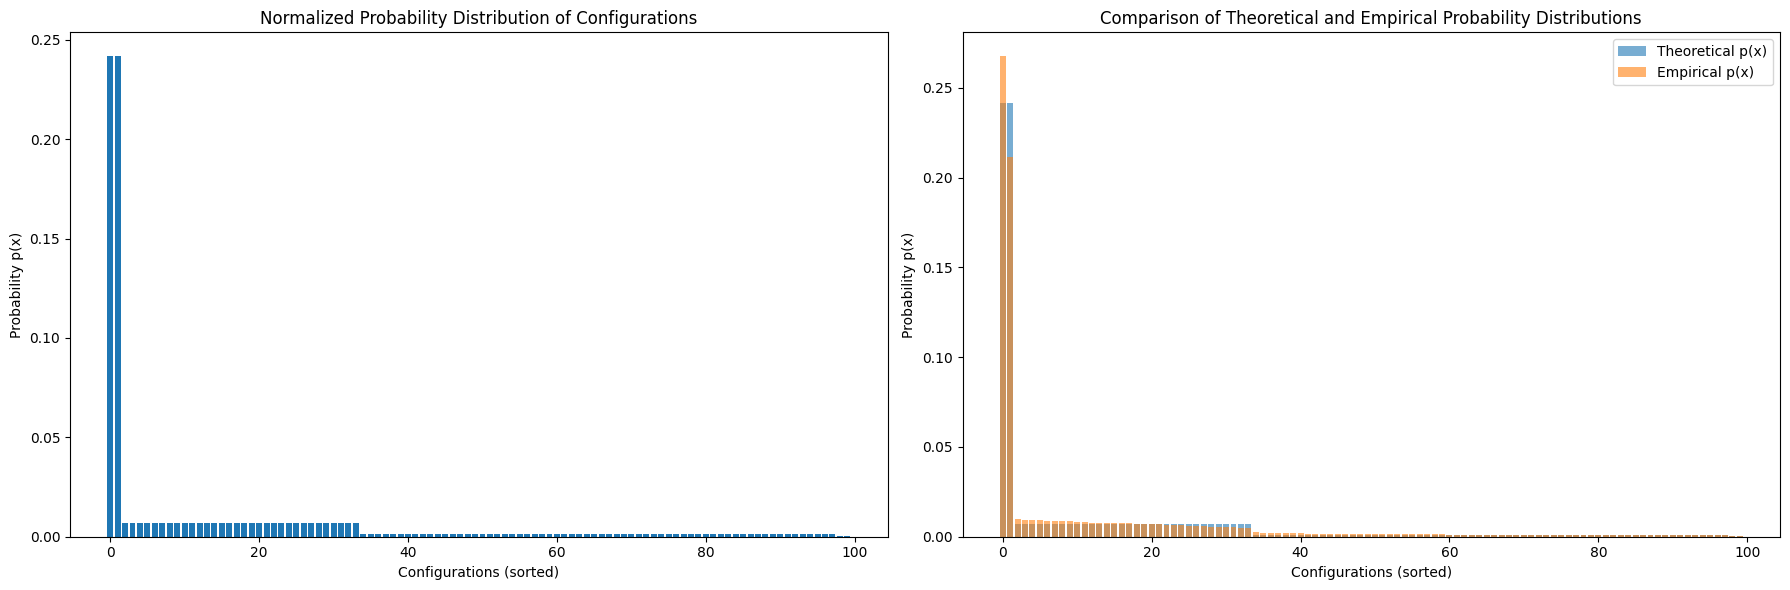

In [7]:
#computing p(x) for each configuration
def compute_px(spins, beta, theta, L):
    spins = np.array(spins).reshape((L, L))
    energy = -theta * np.sum(spins * (np.roll(spins, 1, axis=0) + np.roll(spins, 1, axis=1)))
    return np.exp(-beta * energy)

#capturing spin configurations uniformly for ergodicity check
def capture_spin_configurations_for_ergodicity(L, iterations, temperature, theta, num_samples):
    key = random.PRNGKey(0)
    beta = 1.0 / temperature
    spins = initialize_spins(key, L)
    state = (spins, beta, key, theta)

    def step_fn(state, _):
        spins, beta, key, theta = state
        key, subkey = random.split(key)
        state, _ = lax.scan(step, state, None, length=iterations // num_samples)
        return state, state[0].flatten()

    _, samples = lax.scan(step_fn, state, None, length=num_samples)
    return samples

#generating random spin configuration
def initialize_spins(key, L):
    return random.choice(key, jnp.array([-1, 1]), shape=(L, L))  #randomly choosing between -1 and 1

@jit  #single Metropolis-Hastings step
def step(state, _):
    spins, beta, key, theta = state
    L = spins.shape[0]
    i, j = random.randint(key, (2,), 0, L)  

    delta_E = 2 * theta * spins[i, j] * (spins[i, (j+1) % L] + spins[i, (j-1) % L] + spins[(i+1) % L, j] + spins[(i-1) % L, j])
    
    key, subkey = random.split(key)
    accept = (delta_E < 0) | (random.uniform(subkey) < jnp.exp(-beta * delta_E))  
    spins = spins.at[i, j].set(lax.select(accept, -spins[i, j], spins[i, j]))
    return (spins, beta, key, theta), accept

def main():
    L = 4  #cheap grid size for ergodicity test
    iterations = 100000
    theta = 1.0
    T_c = 2 * theta / (jnp.log(1 + jnp.sqrt(2)))
    num_samples = 10000

    beta = 1.0 / T_c
    all_configurations = list(itertools.product([-1, 1], repeat=L*L))
    print("Total configurations:", len(all_configurations))

    px_values = np.array([compute_px(config, beta, theta, L) for config in all_configurations])
    px_values /= np.sum(px_values)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    #theoretical p(x)
    sorted_px = np.sort(px_values)[::-1]

    axes[0].bar(range(100), sorted_px[:100])  #top 100 for plot clarity
    axes[0].set_xlabel('Configurations (sorted)')
    axes[0].set_ylabel('Probability p(x)')
    axes[0].set_title('Normalized Probability Distribution of Configurations')

    #empirical p(x)
    samples = capture_spin_configurations_for_ergodicity(L, iterations, T_c, theta, num_samples)
    empirical_counts = np.zeros(len(all_configurations))
    for sample in samples:
        index = all_configurations.index(tuple(sample.tolist()))
        empirical_counts[index] += 1
    empirical_px = empirical_counts / np.sum(empirical_counts)
    sorted_empirical_px = np.sort(empirical_px)[::-1]

    axes[1].bar(range(100), sorted_px[:100], alpha=0.6, label='Theoretical p(x)')  #top 100 for plot clarity
    axes[1].bar(range(100), sorted_empirical_px[:100], alpha=0.6, label='Empirical p(x)')
    axes[1].set_xlabel('Configurations (sorted)')
    axes[1].set_ylabel('Probability p(x)')
    axes[1].legend()
    axes[1].set_title('Comparison of Theoretical and Empirical Probability Distributions')

    plt.tight_layout()
    plt.show()

main()

